# Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import Libraries

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import os
import matplotlib.pylab as plt
import statsmodels.api as sm
from geopandas import GeoDataFrame
from fiona.crs import from_epsg
import pysal as ps
import seaborn as sns
from matplotlib import colors
import shapely

#PUIdata = path to PUIdata Folder
PUIdata = '/gpfs1/cusp/tg1478/PUIdata'                                                                                                          

## Working with Shape File

### Loading Census Tract Shape File

In [5]:
shape_path = PUIdata + '/Data/CT_Shape/ct_shape.shp'
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index = ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [6]:
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area = ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

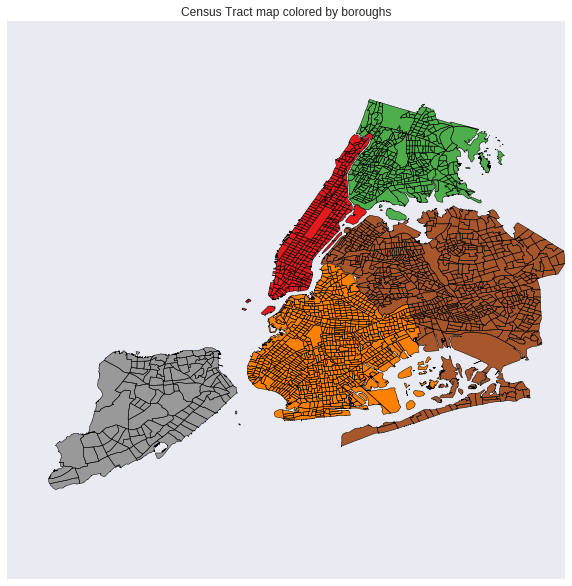

In [37]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

Figure 1: The figure above displays the census tract blocks of the 5 New York City boroughs. 

### Map NYC Population density

#### Load Census Data for 2010

In [8]:
ct_data = DataFrame.from_csv(PUIdata + '/Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index = ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [9]:
ct_shape_pop = ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Visualize the Population density for 2010

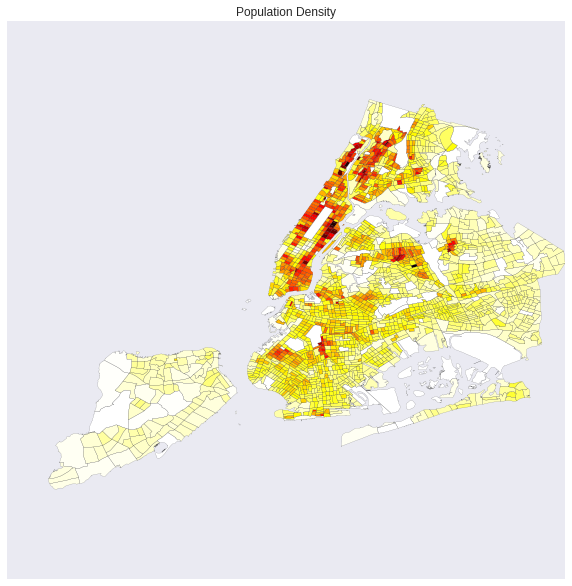

In [40]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

Figure 2: The figure above is a heat map visualization of the New York City population density during the year 2010. 

## Explore CitiBike data

### Load CitiBike data

In [28]:
df_bike_monthly = DataFrame.from_csv(PUIdata + '/Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Time Series Aanalysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


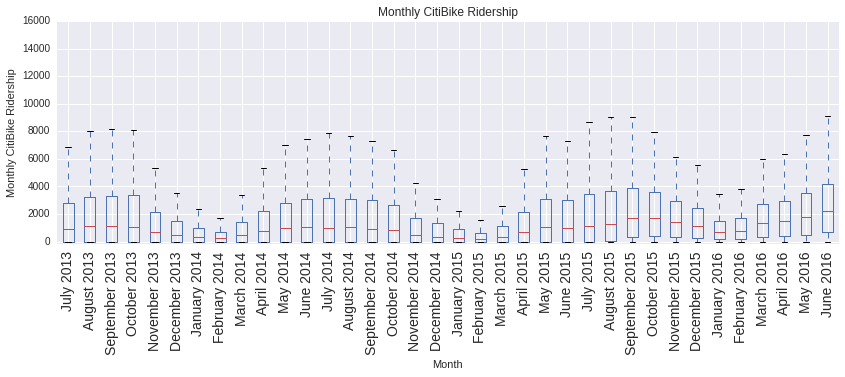

In [29]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_ = df_bike_monthly.copy()
df_bike_monthly_.index = df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])
ax.set_xlabel('Month')
ax.set_ylabel('Monthly CitiBike Ridership')
ax.set_title('Monthly CitiBike Ridership')

Figure 3: The figure above is a time series analysis of monthly CitiBike ridership. The data is displayed in box-plot method. Seasonal periodicity is evident in the graph. 

#### Seasonal Decomposition

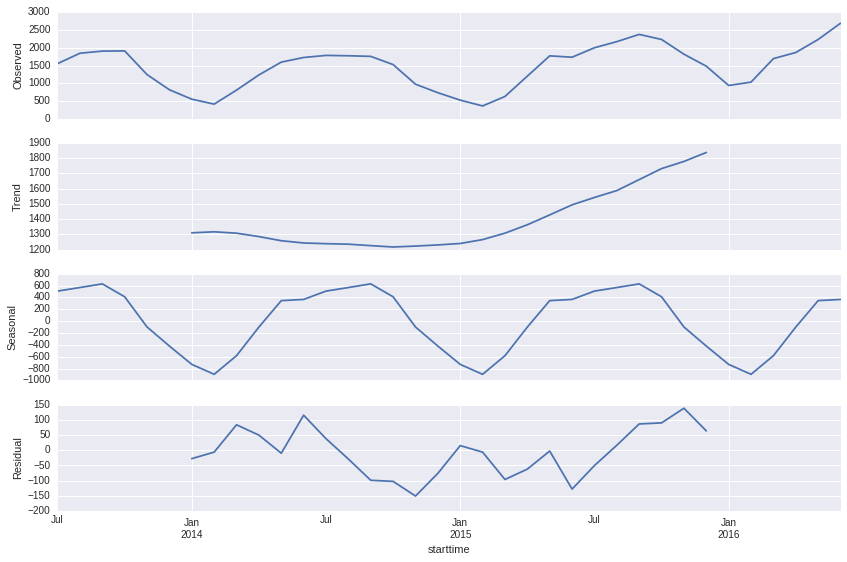

In [30]:
#Create a monthly time series of bike ride (Average of all citibike stations)
df_new = df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

Figure 4: The figures above display the seasonal decomposition of the CitiBike data. Represented is the observed data, trends within the data, seasonaility and residuals of the data. 

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [1]:
station_id = DataFrame.from_csv(PUIdata + '/Data/Station_id.csv')
#convert station_ids to string index
station_id.index = station_id.index.astype(str)
station_id.head()

NameError: name 'DataFrame' is not defined

### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [32]:
# combine lat and lon to one column
station_id['lonlat'] = zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry'] = station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [33]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [34]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

## Group Rides by Season

In [35]:
# Create data frame for seasons
df_bike_season = df_bike_monthly.copy()

# Map seasons to month indices 
df_bike_season['Summer'] = [i.month in [4,5,6,7,8,9] for i in df_bike_monthly.index]
df_bike_season['Winter'] = [i.month in [1,2,3,10,11,12] for i in df_bike_monthly.index]

# Sum season ridership
df_bike_season = df_bike_season.groupby('Summer').sum()
df_bike_season = df_bike_season.groupby('Winter').sum()

df_bike_season.index = ['Summer','Winter']

df_bike_season = df_bike_season.T

df_bike_season['Station_ID'] = df_bike_season.index

df_bike_season.head()

,Summer,Winter,Station_ID
1000,42378,26930,1000
1001,67646,35178,1001
1002,169085,104440,1002
1003,64084,37865,1003
1004,116324,67720,1004


### Add Seasonal Rides

In [45]:
station_id['Station_ID'] = station_id.index
station_id = station_id.join(df_bike_season, lsuffix = 'Station_ID')

### Add monthly rides to the station GeoDataFrame with CT code

In [46]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['MonthlyAve'] = df_bike_monthly.sum()

In [47]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,Station_IDStation_ID,SummerStation_ID,WinterStation_ID,Station_IDStation_ID,Summer,Winter,Station_ID,MonthlyAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,1000,42378,26930,1000,42378,26930,1000,69308
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,1001,67646,35178,1001,67646,35178,1001,102824
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,1002,169085,104440,1002,169085,104440,1002,273525
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,1003,64084,37865,1003,64084,37865,1003,101949
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,1004,116324,67720,1004,116324,67720,1004,184044


### Add the seasonal average rides to the CT shapefile 

In [48]:
temp = station_id[['Summer','Winter']]
temp['station_id'] = station_id.index
temp.index = station_id['BoroCT2010']
ct_shape_season = ct_shape.join(temp)
ct_shape_season.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


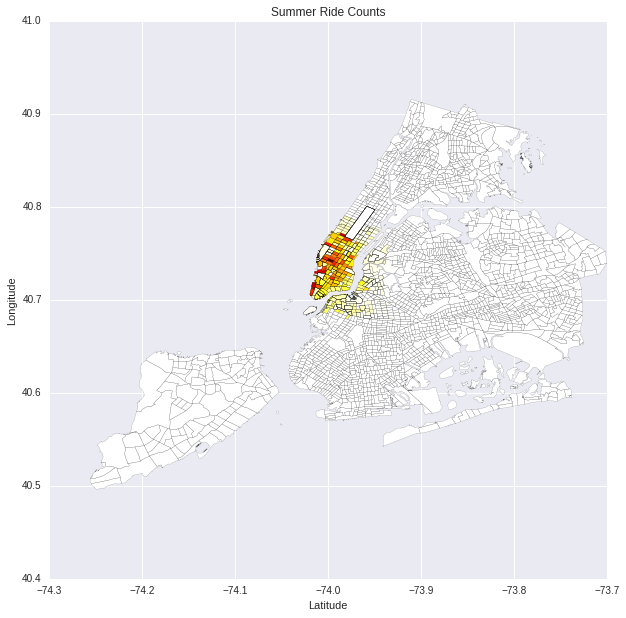

In [49]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_season.plot(column='Summer',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Ride Counts")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

Figure 5: Zoomed out view of New York City CitiBike ridership counts by Census Tract during the summer.

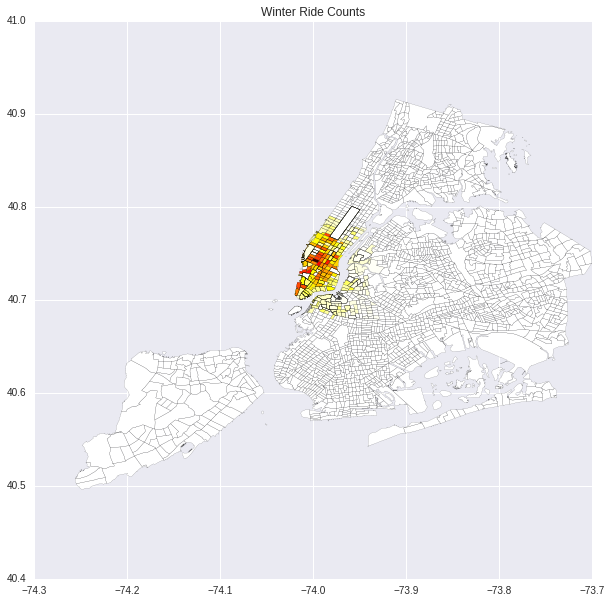

In [50]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_season.plot(column='Winter',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Ride Counts")

Figure 6: Zoomed out view of New York City CitiBike ridership counts by Census Tract during the winter.

### Removing the CTs that are out of zoom boundries

In [23]:
ct_shape_season_Zoom = (ct_shape_season[ct_shape_season
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

### Map the seasonal rides 

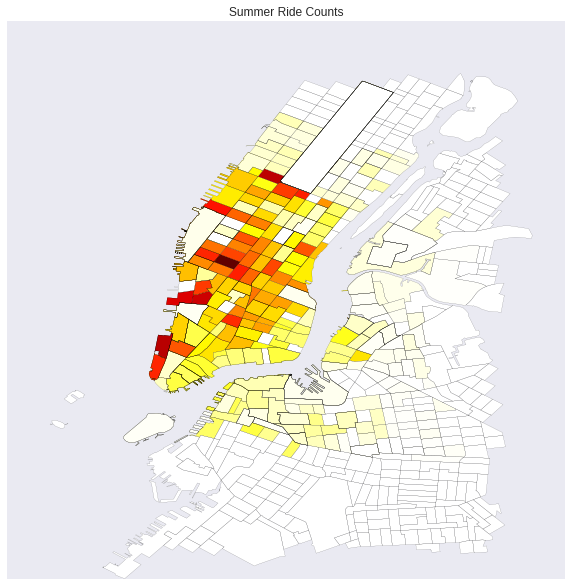

In [24]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_season_Zoom.plot(column='Summer',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Ride Counts")

Figure 7: Zoomed in view of New York City CitiBike ridership counts by Census Tract during the summer.

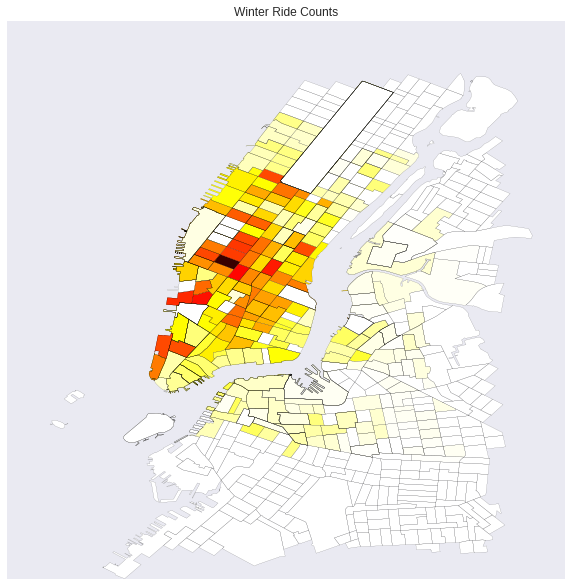

In [25]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_season_Zoom.plot(column='Winter',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Ride Counts")

Figure 8: Zoomed in view of New York City CitiBike ridership counts by Census Tract during the winter.

### Export Shapefile CTs in the CitiBike Zone

In [28]:
path = PUIdata + '/Data/Output/ct_shape_season_Zoom.shp'
ct_shape_season_Zoom.to_file(path)

## Exploratory Geospatial Analysis

### Spatial Weights
Contiguity: Queen Weights

In [29]:
qW_CT = ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [30]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [31]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [34]:
Wmatrix, ids = qW_CT.full()

In [35]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [36]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [38]:
SummerRide = ct_shape_season_Zoom.Summer
SummerRideLag = ps.lag_spatial(qW_CT, SummerRide)

WinterRide = ct_shape_season_Zoom.Winter
WinterRideLag = ps.lag_spatial(qW_CT, WinterRide)

#### Create Quantiles for maping

In [39]:
SummerRideLagQ10 = ps.Quantiles(SummerRideLag, k=10)
print SummerRideLagQ10

WinterRideLagQ10 = ps.Quantiles(SummerRideLag, k=10)
print WinterRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               140
    0.000 < x[i] <=   137.571                21
  137.571 < x[i] <=  2404.850                78
 2404.850 < x[i] <=  5510.364                80
 5510.364 < x[i] <= 11145.782                79
11145.782 < x[i] <= 16953.467                80
16953.467 < x[i] <= 36421.278                79
36421.278 < x[i] <= 52710.200                80
52710.200 < x[i] <= 61019.750                79
61019.750 < x[i] <= 94018.643                80
                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               140
    0.000 < x[i] <=   137.571                21
  137.571 < x[i] <=  2404.850                78
 2404.850 < x[i] <=  5510.364                80
 5510.364 < x[i] <= 11145.782                79
11145.782 < x[i] <= 16953.467                80
16953.467 < x[i] <= 36421.278       

#### Map the sesonal rides lag

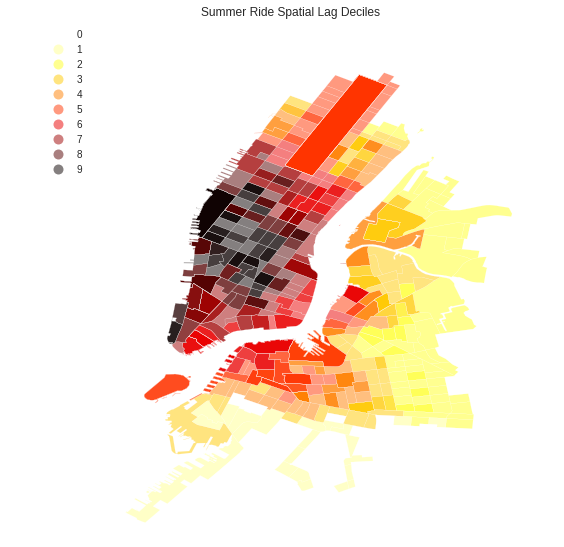

In [40]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_season_Zoom.assign(cl=SummerRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Summer Ride Spatial Lag Deciles")

Figure 9: Heatmap of New York City CitiBike ridership spatial lag by Census Tract during the summer.

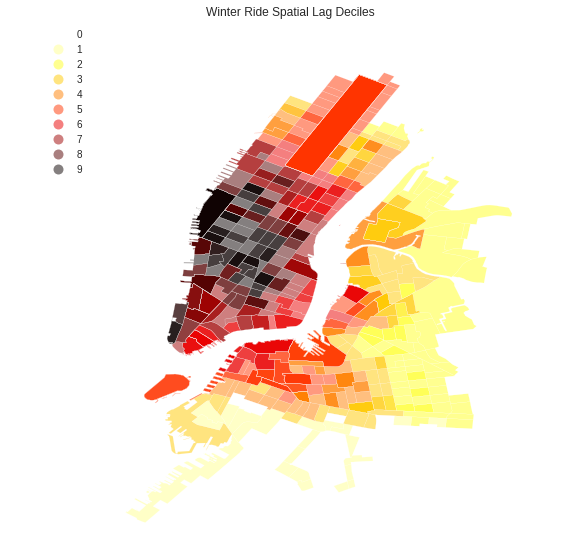

In [41]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_season_Zoom.assign(cl=WinterRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Winter Ride Spatial Lag Deciles")

Figure 10: Heatmap of New York City CitiBike ridership spatial lag by Census Tract during the winter.

## Global  Spatial Autocorrelation

In [42]:
b,a = np.polyfit(SummerRide, SummerRideLag, 1)
print b,a 

b2,a2 = np.polyfit(WinterRide, WinterRideLag, 1)
print b2,a2

0.64466687635 8128.84426008
0.659622410902 4623.78156251


### Moran Scatterplot

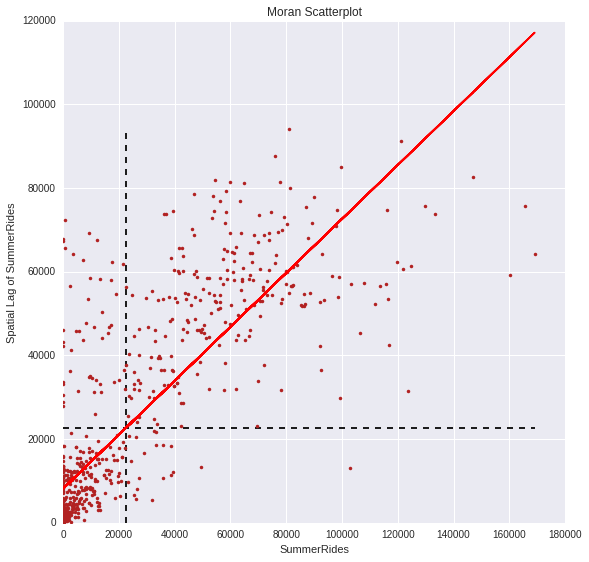

In [43]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(SummerRide, SummerRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(SummerRide, a + b*SummerRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of SummerRides')
plt.xlabel('SummerRides')

Figure 11: Moran scatterplot of New York CitiBike ridership lag during the summer. There is a positive correlation represented in the data. 

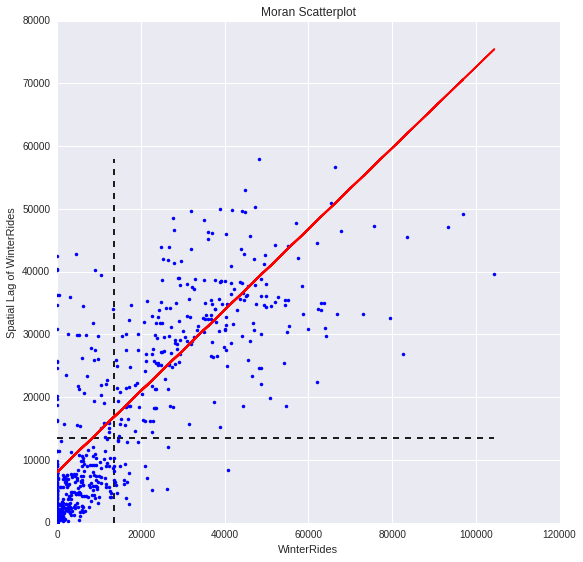

In [44]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(WinterRide, WinterRideLag, '.', color='blue')

 # dashed vert at mean of the last year's PCI
plt.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(WinterRide, a + b*WinterRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of WinterRides')
plt.xlabel('WinterRides')

Figure 12: Moran scatterplot of New York CitiBike ridership lag during the winter. There is a positive correlation represented in the data. 

### Moran's I

In [46]:
I_SummerRide = ps.Moran(SummerRide, qW_CT)
I_WinterRide = ps.Moran(WinterRide, qW_CT)

In [47]:
print I_SummerRide.I, I_SummerRide.p_sim
print I_WinterRide.I, I_WinterRide.p_sim

0.644825188485 0.001
0.659777186107 0.001


Thus, the $I$ statistic is $0.64$ for Summer and $0.65$ for Winter for this data. Each has a very small $p$ value. 

In [48]:
I_SummerRide.sim[0:10]

array([-0.00956566,  0.00145155, -0.01223066, -0.00438296,  0.00879769,
       -0.01091712, -0.03192585, -0.01721471, -0.02712986, -0.00400421])

In [49]:
I_WinterRide.sim[0:10]

array([-0.00732945, -0.02725201,  0.00834461,  0.01084866, -0.00115318,
        0.0075072 ,  0.00623448,  0.00419214,  0.05144415,  0.01113476])

### KDEplot of all of the simulated points

In [52]:
plt.rcParams['figure.figsize']=(14,3)

(-0.7, 0.7)

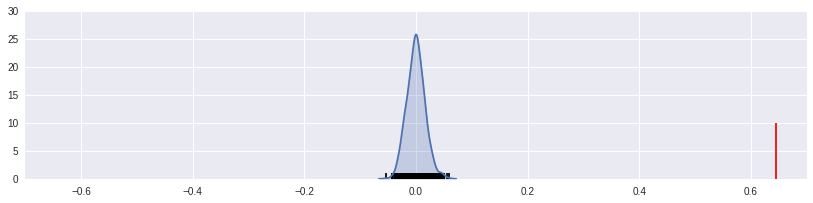

In [53]:
sns.kdeplot(I_SummerRide.sim, shade=True)
plt.vlines(I_SummerRide.sim, 0, 1)
plt.vlines(I_SummerRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

Figure 13: KDE plot of Morans I for CitiBike summer ridership. The vertical line depicts the observed value. 

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

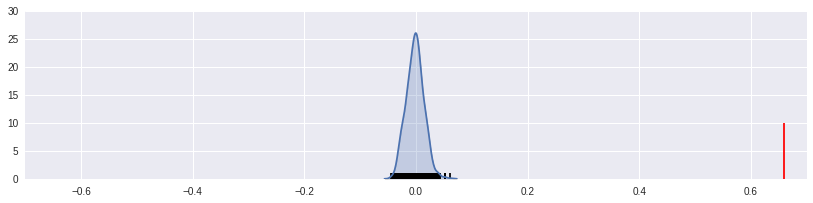

In [55]:
sns.kdeplot(I_WinterRide.sim, shade=True)
plt.vlines(I_WinterRide.sim, 0, 1)
plt.vlines(I_WinterRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

Figure 14: KDE plot of Morans I for CitiBike winter ridership. The vertical line depicts the observed value.  

## Local  Spatial Autocorrelation

In [56]:
LMo_SummerRide = ps.Moran_Local(SummerRide, qW_CT,permutations=999)

In [57]:
LMo_SummerRide.Is[0:5], LMo_SummerRide.p_sim[0:5]

(array([-0.        , -0.23934856,  0.01170042,  0.00166728,  0.021779  ]),
 array([ 0.001,  0.188,  0.347,  0.36 ,  0.391]))

In [58]:
LMo_WinterRide = ps.Moran_Local(WinterRide, qW_CT,permutations=999)

In [59]:
LMo_WinterRide.Is[0:5], LMo_WinterRide.p_sim[0:5]

(array([-0.        , -0.27131052,  0.000345  , -0.00107098, -0.04975374]),
 array([ 0.001,  0.168,  0.475,  0.486,  0.438]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [60]:
sigs = SummerRide[LMo_SummerRide.p_sim <= .001]
W_sigs = SummerRideLag[LMo_SummerRide.p_sim <= .001]
insigs = SummerRide[LMo_SummerRide.p_sim > .001]
W_insigs = SummerRideLag[LMo_SummerRide.p_sim > .001]

sigs1 = WinterRide[LMo_WinterRide.p_sim <= .001]
W_sigs1 = WinterRideLag[LMo_WinterRide.p_sim <= .001]
insigs1 = WinterRide[LMo_WinterRide.p_sim > .001]
W_insigs1 = WinterRideLag[LMo_WinterRide.p_sim > .001]

### Plot Signficant LISA

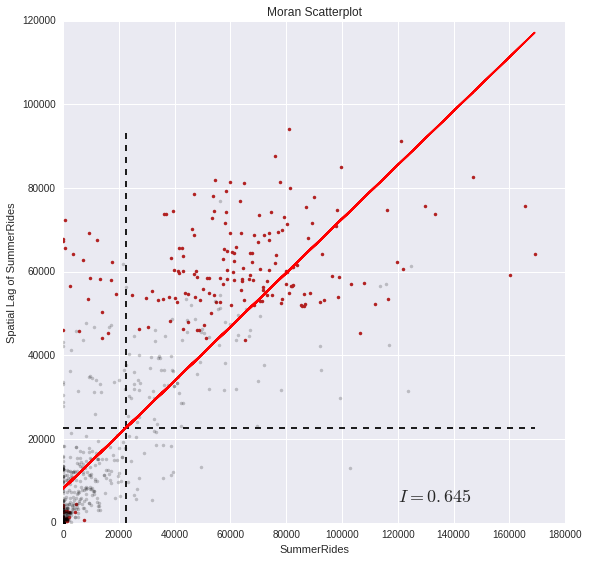

In [65]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_SummerRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(SummerRide, a + b*SummerRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of SummerRides')
plt.xlabel('SummerRides')

Figure 15: Moran scatterplot of CitiBike summer ridership with local indicators of spatial autocorrelation. 

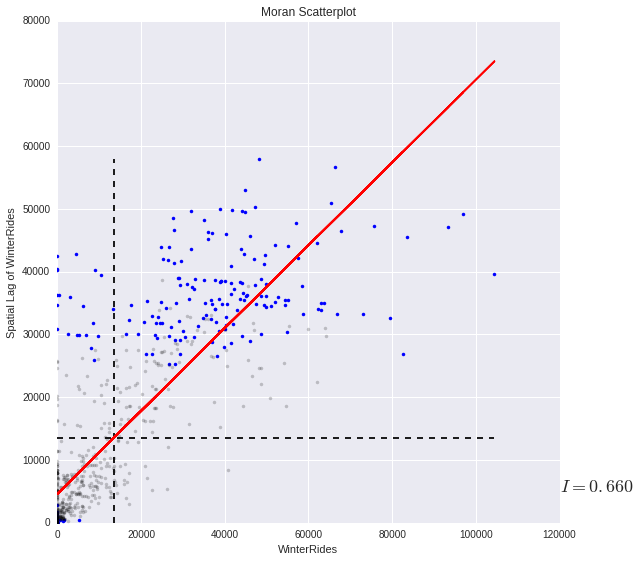

In [67]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs1, W_sigs1, '.', color='blue')
plt.plot(insigs1, W_insigs1, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_WinterRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(WinterRide, a2 + b2*WinterRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of WinterRides')
plt.xlabel('WinterRides')

Figure 16: Moran scatterplot of CitiBike winter ridership with local indicators of spatial autocorrelation. 

### Hot and Cold spots 

In [68]:
# Summer
sig = LMo_SummerRide.p_sim < 0.01
hotspots = LMo_SummerRide.q==1 * sig
coldspots = LMo_SummerRide.q==3 * sig

# Winter
sig1 = LMo_WinterRide.p_sim < 0.01
hotspots1 = LMo_WinterRide.q==1 * sig1
coldspots1 = LMo_WinterRide.q==3 * sig1

print "Number of Summer Hotspots:", hotspots.sum()
print "Number of Summer Coldspots:", coldspots.sum()

print "Number of Winter Hotspots:", hotspots1.sum()
print "Number of Winter Coldspots:", coldspots1.sum()

Number of Summer Hotspots: 190
Number of Summer Coldspots: 231
Number of Winter Hotspots: 191
Number of Winter Coldspots: 265


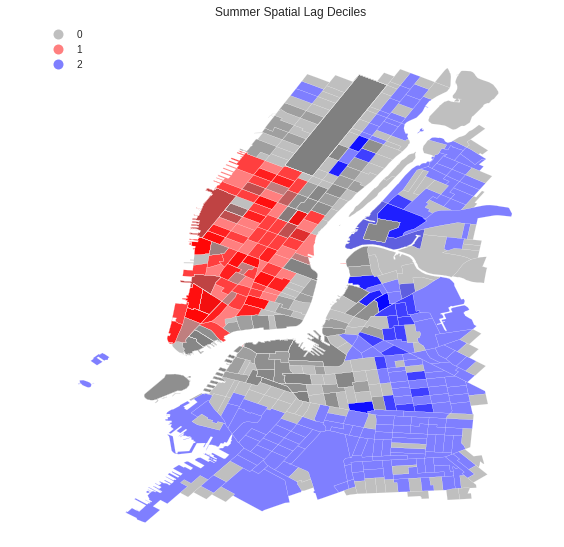

In [74]:
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_season_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Summer Spatial Lag Deciles")

Figure 17: Summer hot spots and cold spots represented by graduated colors. 

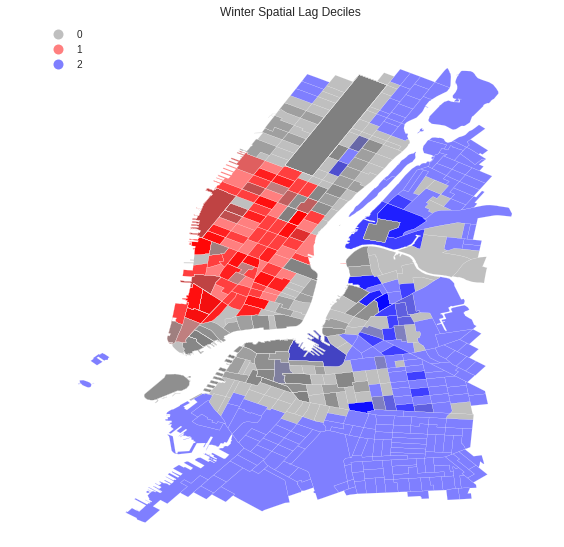

In [75]:
hotcold1 = hotspots1*1 + coldspots1*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_season_Zoom.assign(cl=hotcold1).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Winter Spatial Lag Deciles")

Figure 18: Winter hot spots and cold spots represented by graduated colors. 